In [ ]:
pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.1-py3-none-any.whl size=190074 sha256=830852d90a7142a33c34487a75e6fac5d4fc08980d1943bcd39a4de16d9c8063
  Stored in directory: /root/.cache/pip/wheels/a3/42/d7/48a53ffc1466bd63932f28583c64ebf442114db14a0bfa8c95
Successfully built pyod


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pyod.models.ecod import ECOD

In [ ]:
df = pd.read_csv('top10s-cleaned.csv', encoding = 'latin-1')

In [ ]:
df.head(3)

,Unnamed: 0.1,Unnamed: 0,title,artist,top_genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,0,1,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,1,2,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,2,3,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80


**Checking the different genre names**

In [ ]:
df['top_genre'].unique()

array(['neo mellow', 'detroit hip hop', 'dance pop', 'pop',
       'canadian pop', 'hip pop', 'barbadian pop', 'atl hip hop',
       'australian pop', 'indie pop', 'art pop', 'colombian pop',
       'big room', 'british soul', 'chicago rap', 'acoustic pop',
       'permanent wave', 'boy band', 'baroque pop', 'celtic rock',
       'electro', 'complextro', 'canadian hip hop', 'candy pop',
       'alaska indie', 'folk-pop', 'metropopolis', 'house',
       'australian hip hop', 'electropop', 'australian dance',
       'hollywood', 'canadian contemporary r&b',
       'irish singer-songwriter', 'tropical house', 'belgian edm',
       'french indie pop', 'hip hop', 'danish pop', 'latin',
       'canadian latin', 'electronic trap', 'edm', 'electro house',
       'downtempo', 'brostep', 'contemporary country', 'moroccan pop',
       'escape room', 'alternative r&b'], dtype=object)

**Checking the instances of each genre**

In [ ]:
df['top_genre'].value_counts()

dance pop                    327
pop                           60
canadian pop                  34
barbadian pop                 15
boy band                      15
electropop                    13
british soul                  11
big room                      10
canadian contemporary r&b      9
neo mellow                     9
art pop                        8
complextro                     6
hip pop                        6
australian dance               6
atl hip hop                    5
australian pop                 5
edm                            5
permanent wave                 4
latin                          4
hip hop                        4
colombian pop                  3
tropical house                 3
brostep                        2
downtempo                      2
electronic trap                2
belgian edm                    2
escape room                    2
folk-pop                       2
electro                        2
indie pop                      2
detroit hi

In [ ]:
modified_df = df

**Combining similar genres into groups**

In [ ]:
#adds all instances of pop in the genre column into one shared genre
for i in modified_df.top_genre:
    if 'pop' in i:
        modified_df.top_genre = modified_df.top_genre.replace(i, 'pop')

    elif 'hip hop' in i:
        modified_df.top_genre = modified_df.top_genre.replace(i, 'hip hop')

    elif 'edm' in i:
        modified_df.top_genre = modified_df.top_genre.replace(i, 'edm')

    elif 'r&b' in i:
        modified_df.top_genre = modified_df.top_genre.replace(i, 'pop')

    elif 'latin' in i:
        modified_df.top_genre = modified_df.top_genre.replace(i, 'latin')

    elif 'room' in i:
        modified_df.top_genre = modified_df.top_genre.replace(i, 'room')

    elif 'electro' in i:
        modified_df.top_genre = modified_df.top_genre.replace(i, 'edm')

#replaces all instances of chicago rap with hip hop
modified_df.top_genre = modified_df.top_genre.replace('chicago rap', 'hip hop')

**Checking the instances of different genres again**

In [ ]:
modified_df.top_genre.value_counts()

pop                        495
boy band                    15
hip hop                     15
room                        12
edm                         12
british soul                11
neo mellow                   9
complextro                   6
australian dance             6
latin                        5
permanent wave               4
tropical house               3
brostep                      2
downtempo                    2
alaska indie                 1
irish singer-songwriter      1
hollywood                    1
house                        1
celtic rock                  1
contemporary country         1
Name: top_genre, dtype: int64

**Removing any genres with 3 or less instances**

In [ ]:
cull_df = modified_df
value_counts = cull_df['top_genre'].value_counts()
culled = value_counts[value_counts <= 3].index
cull_df.replace(culled, 'other', inplace=True)
cull_df.top_genre.value_counts()

pop                 495
hip hop              15
boy band             15
other                13
room                 12
edm                  12
british soul         11
neo mellow            9
complextro            6
australian dance      6
latin                 5
permanent wave        4
Name: top_genre, dtype: int64

In [ ]:
cull_df.head()

,Unnamed: 0.1,Unnamed: 0,title,artist,top_genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,0,1,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,1,2,Love The Way You Lie,Eminem,hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,2,3,TiK ToK,Kesha,pop,2010,120,84,76,-3,29,71,200,10,14,80
3,3,4,Bad Romance,Lady Gaga,pop,2010,119,92,70,-4,8,71,295,0,4,79
4,4,5,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


#**Creating various dataframes**

In [ ]:
# datadrame with all numeric feature columns
z = df.iloc[:, 6:]
# dataframe with all numeric feature columns (except year)
y = df.iloc[:, 5:]
# dataframe with top 7 columns suggested by an LLM
x = df.iloc[:, [6,7,8,9,11,12,14]]


# 2 dimensional pca
pca = PCA(2)

# data slection of 7 best columns for improving the cluster based on LLM
data_x = pca.fit_transform(x)

# selects all features to create a cluster with
data_z = pca.fit_transform(z)


x.head()

,bpm,nrgy,dnce,dB,val,dur,spch
0,97,89,67,-4,80,217,4
1,87,93,75,-5,64,263,23
2,120,84,76,-3,71,200,14
3,119,92,70,-4,71,295,4
4,109,84,64,-5,43,221,4


In [ ]:
z.head()

,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,97,89,67,-4,8,80,217,19,4,83
1,87,93,75,-5,52,64,263,24,23,82
2,120,84,76,-3,29,71,200,10,14,80
3,119,92,70,-4,8,71,295,0,4,79
4,109,84,64,-5,9,43,221,2,4,78


#**Creating a K-means clustering of 12 different clusters**

In [ ]:
kmeans = KMeans(n_clusters = 12, init = 'k-means++')
y_kmeans = kmeans.fit_predict(z)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
label = kmeans.fit_predict(data_z)

print(label)

[ 9  6  9  6  0  2  9  0  3  0  0  0  9  9  9  6  9  1  6  8  6  4  9  9
  4  4  9  4  0  0  9  9  8  6  6  9  5  4  4  6  8  5  6  8  3  8  0  0
  1  8  9  5  5  6  0  0  4  9  6 11  9  4  6  7  0 11  6  9  4  6 11  6
  6  4  2  9  1  4  0  9  9  1  4  0  9  9  6  5  0  2  9  6  4  0  3  1
  5  9  9  9  6  4  0 11  6  4  6  0  9  2  8  8  0  2  0  0  9  0  9  9
  0  0  6  2  9  0  0  4  4  4  4  9  4 11  9  2  9  6  4  4  0 11 11  2
  4 11  0  4 11  0  6  4  2  9  6 11  8  8 11  9  8  9  1  4  4  4  0  5
  6 11 11  0  1  6  8  9  0  0  0  4  9  4  6  6  2  2  3  6  7 11  4  9
  3  2  1  9  5  4  9  2  4  0  6  6  0  9  0  5  2  6  5 10  4  4  4  4
  0  6  8  8  3  8  0  2  6  6  6  0 11  9  2  8 11  6 11  2  0  2  4  0
  8  1  9  0  0  0 11  9  9  3  6  9  4  0  0 10  1  6  8  9 10 11  0 11
  0 11  2  6  5  3 11  3  6 11  4  2  2  6 11  2  9  9  8  2  3  0  0 11
  4  0  0  0  9  6  0  1  2  9 11  2  4  2  0 11  9  6 11  9  0 11  0 11
  0  8  0  2  0  4  0  6  9  8  4  9  8  9  8 11  9

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


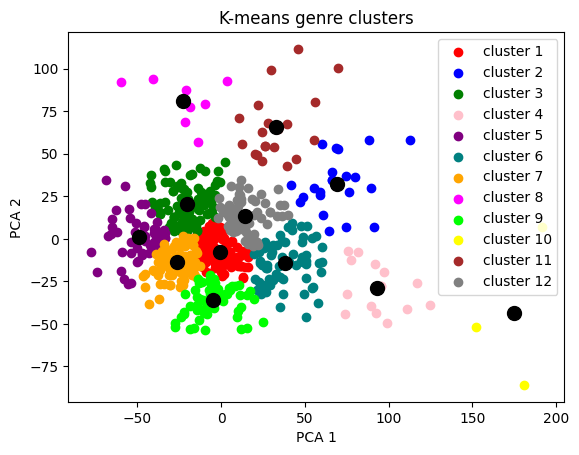

In [ ]:
kmeans = KMeans(n_clusters = 12, init = 'k-means++')
y_kmeans = kmeans.fit_predict(z)

label = kmeans.fit_predict(data_z)

u_labels = np.unique(label)
centroids = kmeans.cluster_centers_



plt.scatter(data_z[label == 0, 0], data_z[label == 0, 1], c = 'red', label = 'cluster 1')
plt.scatter(data_z[label == 1, 0], data_z[label == 1, 1], c = 'blue', label = 'cluster 2')
plt.scatter(data_z[label == 2, 0], data_z[label == 2, 1], c = 'green', label = 'cluster 3')
plt.scatter(data_z[label == 3, 0], data_z[label == 3, 1], c = 'pink', label = 'cluster 4')
plt.scatter(data_z[label == 4, 0], data_z[label == 4, 1], c = 'purple', label = 'cluster 5')
plt.scatter(data_z[label == 5, 0], data_z[label == 5, 1], c = 'teal', label = 'cluster 6')
plt.scatter(data_z[label == 6, 0], data_z[label == 6, 1], c = 'orange', label = 'cluster 7')
plt.scatter(data_z[label == 7, 0], data_z[label == 7, 1], c = 'magenta', label = 'cluster 8')
plt.scatter(data_z[label == 8, 0], data_z[label == 8, 1], c = 'lime', label = 'cluster 9')
plt.scatter(data_z[label == 9, 0], data_z[label == 9, 1], c = 'yellow', label = 'cluster 10')
plt.scatter(data_z[label == 10, 0], data_z[label == 10, 1], c = 'brown', label = 'cluster 11')
plt.scatter(data_z[label == 11, 0], data_z[label == 11, 1], c = 'grey', label = 'cluster 12')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 100, color = 'k')
plt.legend()
plt.title('K-means genre clusters')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

#**K-Means reduced dimensionality**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


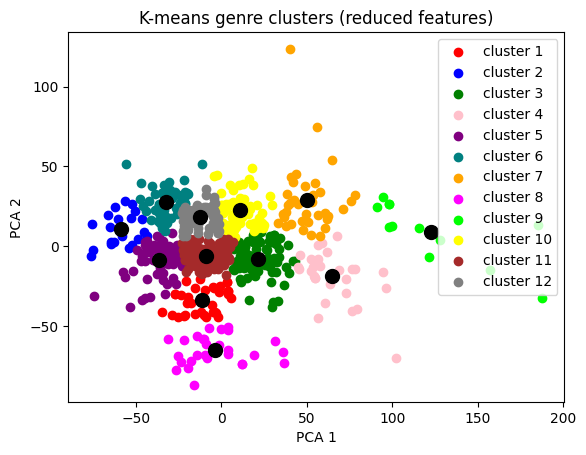

In [ ]:
kmeans = KMeans(n_clusters = 12, init = 'k-means++')
y_kmeans = kmeans.fit_predict(x)

label = kmeans.fit_predict(data_x)

u_labels = np.unique(label)
centroids = kmeans.cluster_centers_


plt.scatter(data_x[label == 0, 0], data_x[label == 0, 1], c = 'red', label = 'cluster 1')
plt.scatter(data_x[label == 1, 0], data_x[label == 1, 1], c = 'blue', label = 'cluster 2')
plt.scatter(data_x[label == 2, 0], data_x[label == 2, 1], c = 'green', label = 'cluster 3')
plt.scatter(data_x[label == 3, 0], data_x[label == 3, 1], c = 'pink', label = 'cluster 4')
plt.scatter(data_x[label == 4, 0], data_x[label == 4, 1], c = 'purple', label = 'cluster 5')
plt.scatter(data_x[label == 5, 0], data_x[label == 5, 1], c = 'teal', label = 'cluster 6')
plt.scatter(data_x[label == 6, 0], data_x[label == 6, 1], c = 'orange', label = 'cluster 7')
plt.scatter(data_x[label == 7, 0], data_x[label == 7, 1], c = 'magenta', label = 'cluster 8')
plt.scatter(data_x[label == 8, 0], data_x[label == 8, 1], c = 'lime', label = 'cluster 9')
plt.scatter(data_x[label == 9, 0], data_x[label == 9, 1], c = 'yellow', label = 'cluster 10')
plt.scatter(data_x[label == 10, 0], data_x[label == 10, 1], c = 'brown', label = 'cluster 11')
plt.scatter(data_x[label == 11, 0], data_x[label == 11, 1], c = 'grey', label = 'cluster 12')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 100, color = 'k')
plt.legend()
plt.title('K-means genre clusters (reduced features)')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [ ]:
cull_df.isnull().any()
cull_df = cull_df.drop_duplicates()
cull_df = cull_df.reset_index(drop=True)

cull_df.bpm = cull_df.bpm.replace(0, cull_df.bpm.mean())
cull_df.dB = cull_df.dB.replace(-60, cull_df.dB.mean())

#**Elbow Method**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

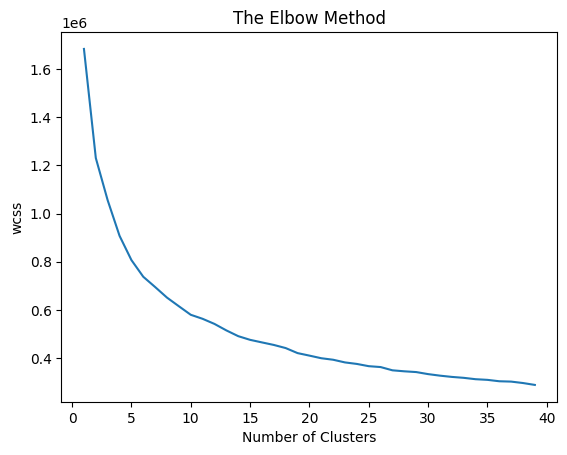

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 40):
  kmeans = KMeans(n_clusters = i, init = 'k-means++') #, random_state = 42)
  kmeans.fit(x)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 40), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

#**Dendrogram**

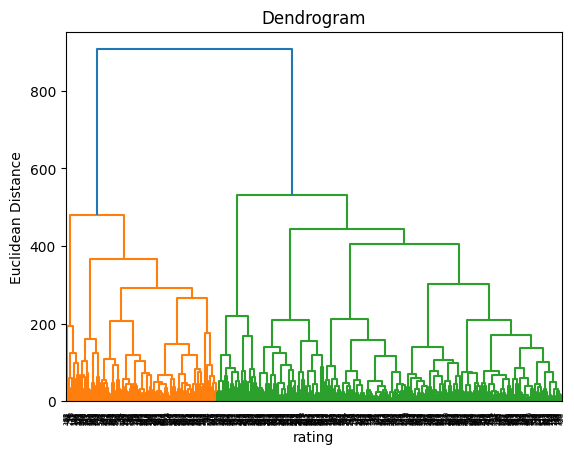

In [ ]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(x, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('rating')
plt.ylabel('Euclidean Distance')
plt.show()

#**Hierachial Clustering**

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 12, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(data_x)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [ ]:
print(y_hc)

[ 1  0  3  5  1  1  3  8  1  8  8  8 10 10 10  5  3  9  0  3  5  4 10  1
  8  2  3  8  8  8 10  2  3  0  8  3  9 10  5  8  2  0  4  3  0  3  1 10
  6  3  3  9  9  8  1  1  8 10  0  1  7  2  5 11  8  0  5 10  4  0  1  5
  0  8 10  3  9  4  8 10 10  9  8  8  3 10  5  0  8  7 10  0  8  1  0  6
  5 10 10 10  5  8  8  1  5  8  9  8  3  1  3  3  0  7 10  0 10  1 10 10
  8  8  0  7 10  8  8  4 10  8  8 10  4  1  3  3  7  8  8  4  8  5  0  7
  4  1 10  8  8  4  5  4  7 10  5  8  3  2  0 10  7 10  6  8  4  8  8  0
  5  1  8  1  6  5  3 10  8  8  8 10 10  4  0  0  7  7  8  0 11  1  8  1
  5  1  6  2  0 10  2  1  4  8  5  5  1  3  8  5  7  0  0  7 10  4  2  2
  8  5  3  3  0  7 10  7  5  5  0  8  1  2  7  7  8  5  8  7 10  7 10  8
  3  9 10  8  8  8  0  2  4  5  5  3  4  4  8  1  9  5  7 10  7  5  8  8
  1  1  1  0  0  1  5  0  5  8  8  1  4  4  5 10  2  1  7  1  8 10  8  0
  4  8  1  8  1  5  8  9  7 10  1  7  2  1  8  1  3  0  0  2  1  1  8  1
  8  2  4 10  8  8  8  5 10  3  8  1  2  2  7  8 10

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


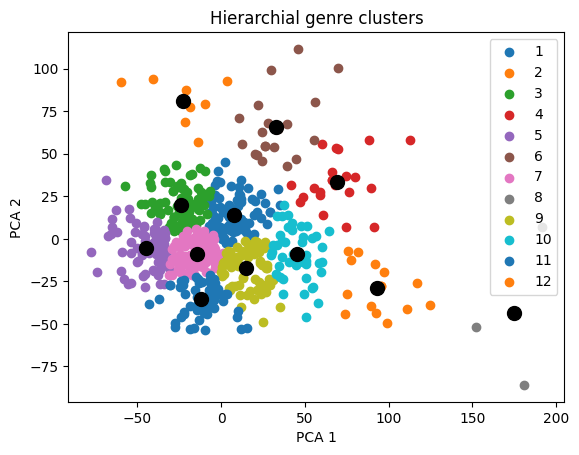

In [ ]:
hc = KMeans(n_clusters = 12, init = 'k-means++')
y_hc = hc.fit_predict(z)

label = hc.fit_predict(data_z)

u_labels = np.unique(label)
centroids = hc.cluster_centers_


# plotting the results:

for i in u_labels:
    plt.scatter(data_z[label == i , 0] , data_z[label == i , 1] , label = i+1)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 100, color = 'k')
plt.legend()
plt.title('Hierarchial genre clusters')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [ ]:
y.head()

,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,2010,97,89,67,-4,8,80,217,19,4,83
1,2010,87,93,75,-5,52,64,263,24,23,82
2,2010,120,84,76,-3,29,71,200,10,14,80
3,2010,119,92,70,-4,8,71,295,0,4,79
4,2010,109,84,64,-5,9,43,221,2,4,78


In [ ]:
# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)

# Normalizing the data so that
# the data approximately follows a Gaussian distribution
y_normalized = normalize(y_scaled)

# Converting the numpy array into a pandas DataFrame
y_normalized = pd.DataFrame(y_normalized)

In [ ]:
pca = PCA(n_components = 2)
y_principal = pca.fit_transform(y_normalized)
y_principal = pd.DataFrame(y_principal)
y_principal.columns = ['P1', 'P2']
print(y_principal.head())

         P1        P2
0 -0.511372 -0.057159
1 -0.312712  0.254685
2 -0.685012  0.036783
3 -0.444750  0.310299
4 -0.299172  0.305925


In [ ]:
# Numpy array of all the cluster labels assigned to each data point
# eps = radius of the cluster around the centroid point
# db_default = DBSCAN(eps = 0.0795, min_samples = 4).fit(y_principal)
db_default = DBSCAN(eps = 0.0785, min_samples = 4).fit(y_principal)
labels = db_default.labels_

print(np.unique(labels))

[-1  0  1  2  3  4  5  6  7  8  9 10 11]


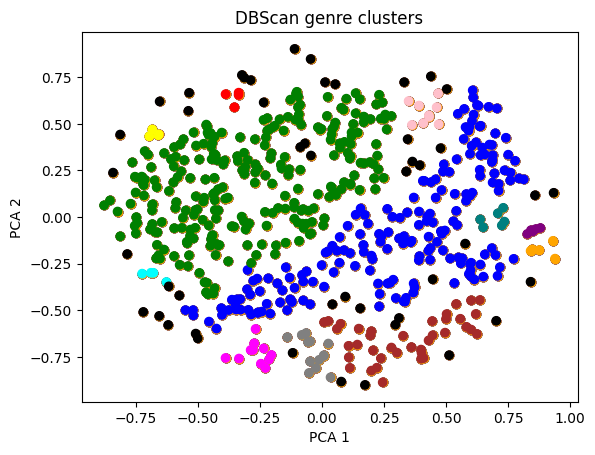

In [ ]:
# Building the label to colour mapping
colours = {}
colours[-1] = 'black'
colours[0] = 'green'
colours[1] = 'blue'
colours[2] = 'yellow'
colours[3] = 'pink'
colours[4] = 'red'
colours[5] = 'teal'
colours[6] = 'magenta'
colours[7] = 'cyan'
colours[8] = 'purple'
colours[9] = 'brown'
colours[10] = 'grey'
colours[11] = 'orange'


# Building the colour vector for each data point
cvec = [colours[label] for label in labels]

# For the construction of the legend of the plot
black = plt.scatter(y_principal['P1'], y_principal['P2'], color ='black');
green = plt.scatter(y_principal['P1'], y_principal['P2'], color ='green');
blue = plt.scatter(y_principal['P1'], y_principal['P2'], color ='blue');
yellow = plt.scatter(y_principal['P1'], y_principal['P2'], color ='yellow');
pink = plt.scatter(y_principal['P1'], y_principal['P2'], color ='pink');
red = plt.scatter(y_principal['P1'], y_principal['P2'], color ='red');
teal = plt.scatter(y_principal['P1'], y_principal['P2'], color ='teal');
magenta = plt.scatter(y_principal['P1'], y_principal['P2'], color ='magenta');
cyan = plt.scatter(y_principal['P1'], y_principal['P2'], color ='cyan');
purple = plt.scatter(y_principal['P1'], y_principal['P2'], color ='purple');
brown = plt.scatter(y_principal['P1'], y_principal['P2'], color ='brown');
grey = plt.scatter(y_principal['P1'], y_principal['P2'], color ='grey');
orange = plt.scatter(y_principal['P1'], y_principal['P2'], color ='orange');

# Plotting P1 on the X-Axis and P2 on the Y-Axis
# according to the colour vector defined
#plt.figure(figsize =(9, 9))
plt.scatter(y_principal['P1'], y_principal['P2'], c = cvec)

#plt.legend((black, green, blue, yellow), ('Label 0', 'Label 1', 'Label 2', 'Label -1'))
plt.title('DBScan genre clusters')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()